###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2014 L.A. Barba, G.F. Forsyth, C. Cooper. Based on [CFDPython](https://github.com/barbagroup/CFDPython), (c)2013 L.A. Barba, also under CC-BY license.

# Пространство и время

## Устойчивость и условие Куранта-Фридрихса-Леви

С возвращением! Перед вами второй блокнот IPython по теме *Пространство и Время: Введение в конечно-разностные схемы для систем дифференциальных уравнений в частных производных*, второго модуля русской версии курса ["Practical Numerical Methods with Python"](http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about)

На первом занятии этой серии мы исследовали численное решение линейного и нелинейного уравнений переноса, полученное при помощи метода конечных разностей. Если вы экспериментировали с различными параметрами численной схемы, то, возможно, в некторых случаях могли наблюдать, что решение ведет себя необычно. Порою даже разваливается, причем весьма эффектно.

В этом ноутбуке мы рассмотрим, почему изменение параметров дискретизации может так радикально повлиять на решение.

Согласно изначальной постановке, пространственная сетка содержит 41 узел, а шаг по времени составляет 0.25. Начем наши эксперименты с изменения количества узлов расчетной сетки. Код в следующей ячейке соответствует линейной постановке, но переписан так, чтобы было удобно наблюдать, что изменинтся, если менять только один параметр: **размерность сетки**.

In [1]:
import numpy                       
from matplotlib import pyplot    
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
def linearconv(nx):
    """Solve the linear convection equation.
    
    Solves the equation d_t u + c d_x u = 0 where 
    * the wavespeed c is set to 1
    * the domain is x \in [0, 2]
    * 20 timesteps are taken, with \Delta t = 0.025
    * the initial data is the hat function
    
    Produces a plot of the results
    
    Parameters
    ----------
    
    nx : integer
        number of internal grid points
        
    Returns
    -------
    
    None : none
    """
    dx = 2/(nx-1)
    nt = 20    
    dt = .025  
    c = 1
    
    x = numpy.linspace(0,2,nx)

    u = numpy.ones(nx)
    lbound = numpy.where(x >= 0.5)
    ubound = numpy.where(x <= 1)
    u[numpy.intersect1d(lbound, ubound)]=2  

    un = numpy.ones(nx) 

    for n in range(nt): 
        un = u.copy() 
        u[1:] = un[1:] -c*dt/dx*(un[1:] -un[0:-1]) 
        u[0] = 1.0
        

    pyplot.plot(x, u, color='#003366', ls='--', lw=3)
    pyplot.ylim(0,2.5);  

Посмотрим, что будет происходить с решением при последовательном измельчении ячейки расчетной сетки. Попробуем сетку с 41, 61, и 71 ячейками, а затем скакнем аж на 85. 

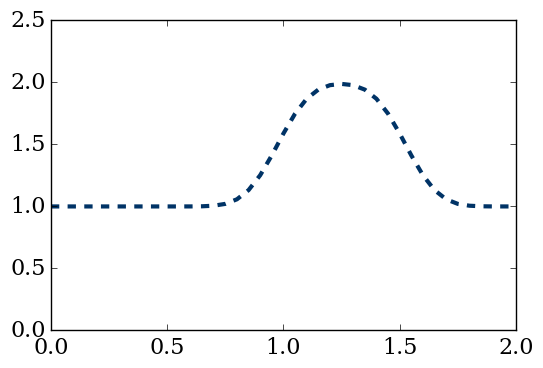

In [3]:
linearconv(41) #convection using 41 grid points

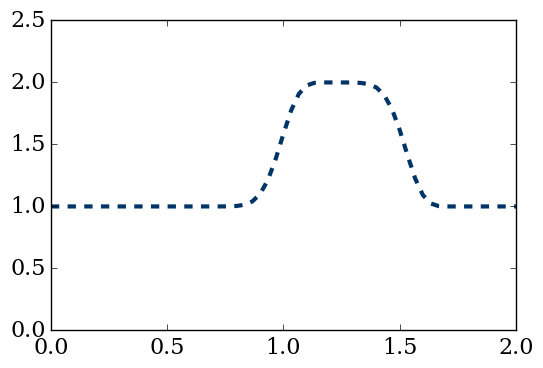

In [4]:
linearconv(61)

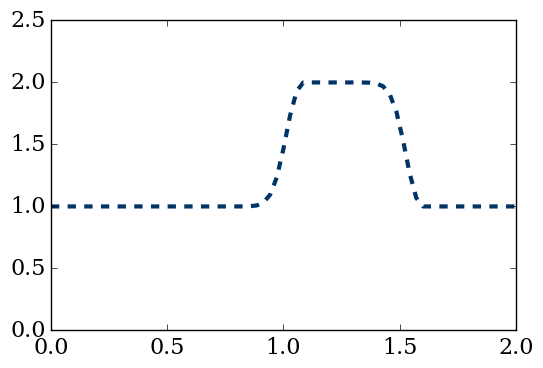

In [5]:
linearconv(71)

Пока все в порядке — чем подробнее сетка, тем "квадратнее" волна, что свидетельствует об уменьшении ошибки дискретизации. Но что случится, если еще немного измельчить сетку? Попробуем 85 узлов:

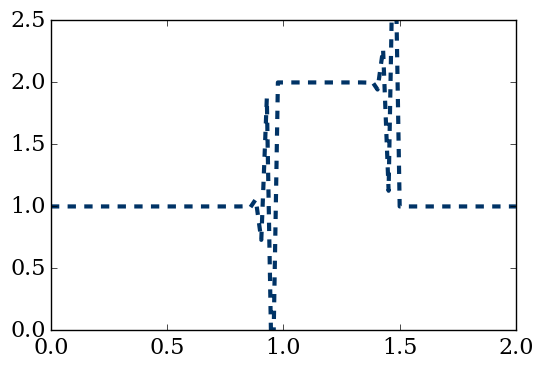

In [6]:
linearconv(85)

Опаньки, ничего общего с изначальной ступенькой. Все пошло вкривь и вкось. А поскольку это тот же самый код, что и прежде, вероятность того, что мы наблюдаем банальный баг программирования, крайне мала.

### Что случилось?

Для ответа на этот вопрос нужно более детально разобраться, что именно реализовано в программе для решения линейного уравнения переноса левым уголком.

На каждой итерации цикла по времени для получения решения на последующем слое $n+1$ используются известные данные о решении на текущем слое $n$. Во всех рассмотренных данных, кроме последнего, увеличение числа узлов расчетной сетки повышало точность получаемого решения. Ошибка дисктретизации уменьшалась, а волна приобретала более квадратную форму по сравнению с той, что получалась в самом начале.

На каждой итерация по времени волна распространялась на шаг $\Delta t$, равный 0.025. В процессе итерации в каждом узле расчетной сетки $x_i$ вычислялось решение $u$. Но последний график ясно свидетельствует, что что-то пошло не так. 

В последнем из рассмотренных случаев расстояние, проходимое волной за время $\Delta t$, оказалось большим, чем `dx`, и решение стало *неустойчивым* (это можно доказать математически, ниже мы это проделаем). Размер ячейки `dx` обратно пропорционален числу ячеек `nx`: мы взяли больше узлов сетки, и `dx` уменьшился. А когда он стал меньше, чем $c\Delta t$ — расстояния, проходимого волной за один шаг по времени, численная схема перестала корректно аппроксимировать уравнение.

![CFLcondition](figures/CFLcondition.png)
#### Графическая интерпретация условия КФЛ.

Рассмотрим иллюстрацию, приведенную выше. Зеленый треугольник представляет _область зависмости_ численной схемы. Действительно, для каждого шага по времени переменная $u_i^{n+1}$ зависит только от значений values $u_i^{n}$ и $u_{i-1}^{n}$.

Если расстояние $c\Delta t$ меньше $\Delta x$, характеристика, выпущенная из узла сетки с индексами $i, n+1$ пересекает сеточную линию $n=const$  _между_ точками $i-1,n$ и $i,n$. В этом случае можно сказать, что _математическая область зависимости_ исходного уравнения в частных производных лежит внутри _области зависимости_ численной схемы.

В противном случае, если  $\Delta x$ меньше $c\Delta t$, _область зависимости_ численной схемы не содержит всей информации для получения решения $u_i^{n+1}$, так как характеристика, выпущенная их точки $i, n+1$ проходит до точки  $i-1,n$.

Требование, что область зависимости исходного уравнения в частных производных должна лежать внутри _численной_ области зависимости численной схемы, можно формализовать:

\begin{equation}\sigma = \frac{c \Delta t}{\Delta x} \leq 1 
\end{equation}

Можно доказать, что для того, чтобы схема была устойчива, необходимо, чтобы шаг по времени `dt` был связан с размером ячейки `dx` приведенным выше соотношением.

Отношение  $c\Delta t/\Delta x$ называется **числом Куранта-Фридрихса-Леви** (Courant-Friedrichs-Lewy number, CFL), и обычно обозначается буквой $\sigma$. Значение $\sigma_{\text{max}}$, которое обеспечивает устойчивлсть зависит от схемы, для используемой схемы "левый уголок" условие устойчивости записывается как $\sigma<1$.

В новой версии кода, на этот раз более безопасной, воспользуемся полученными знаниями, чтобы вычислить подходящий шаг по времени `dt`.

In [8]:
def linearconv(nx):
    """Solve the linear convection equation.
    
    Solves the equation d_t u + c d_x u = 0 where 
    * the wavespeed c is set to 1
    * the domain is x \in [0, 2]
    * 20 timesteps are taken, with \Delta t computed using the CFL 0.5
    * the initial data is the hat function
    
    Produces a plot of the results
    
    Parameters
    ----------
    
    nx : integer
        number of internal grid points
        
    Returns
    -------
    
    None : none
    """
    dx = 2/(nx-1)
    nt = 20    
    c = 1
    sigma = .5
    x = numpy.linspace(0,2,nx)
    
    dt = sigma*dx

    u = numpy.ones(nx) 
    lbound = numpy.where(x >= 0.5)
    ubound = numpy.where(x <= 1)
    u[numpy.intersect1d(lbound, ubound)]=2 

    un = numpy.ones(nx)

    for n in range(nt):  
        un = u.copy() 
        u[1:] = un[1:] -c*dt/dx*(un[1:] -un[0:-1]) 
        u[0] = 1.0
        
    pyplot.plot(x, u, color='#003366', ls='--', lw=3)
    pyplot.ylim(0,2.5);

Теперь вне зависимости от числа ячеек в расчетной сетке решение остается устойчивым.

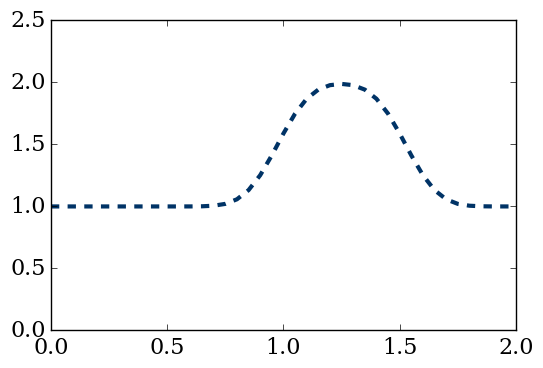

In [9]:
linearconv(41)

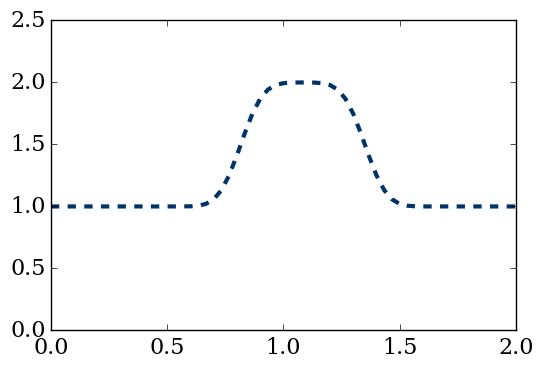

In [10]:
linearconv(61)

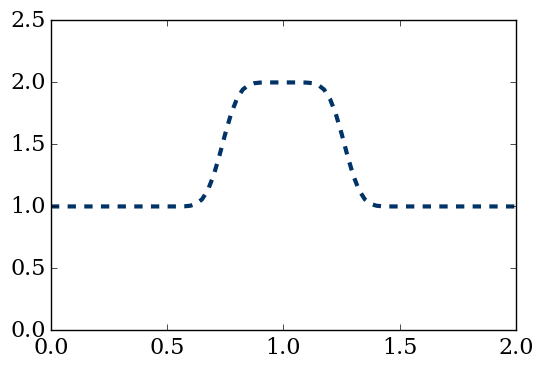

In [11]:
linearconv(81)

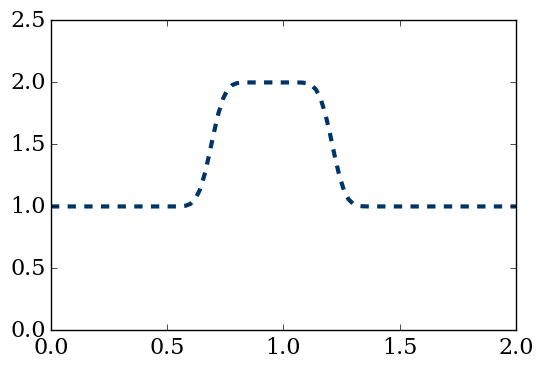

In [12]:
linearconv(101)

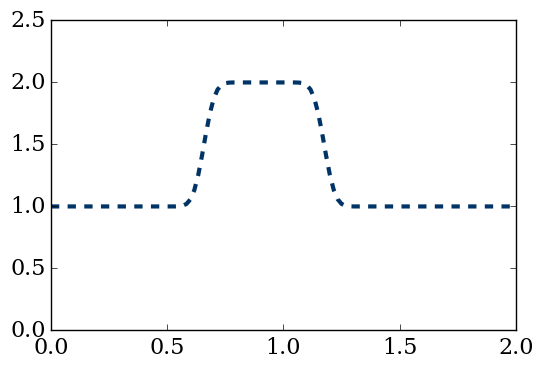

In [13]:
linearconv(121)

Заметим, что при увеличении числа узлов `nx` волна распространяется на меньшее расстояние. Число шагов по времени остается постоянным  `nt = 20`, но рост `nx` приводит к уменьшению `dx` и `dt`, вследствие чего общий интервал времени уменьшается.

---

###### The cell below loads the style of the notebook.

In [13]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())